
# Download the Unsplash dataset (photos) and Create the RAMP Dataset

This notebook is used to download all images from the Unsplash dataset: https://github.com/unsplash/datasets. version Lite (25000 images) 


In [1]:
from pathlib import Path

unsplash_dataset_path = Path("unsplash-research-dataset-lite-latest")

## Load the dataset

The `photos.tsv000` contains metadata about the photos in the dataset, but not the photos themselves. We will use the URLs of the photos to download the actual images.

In [2]:
import pandas as pd

# Read the photos table
photos = pd.read_csv(unsplash_dataset_path / "photos.tsv000", sep='\t', header=0)

# Extract the IDs and the URLs of the photos
photo_urls = photos[['photo_id', 'photo_image_url']].values.tolist()

# Print some statistics
print(f'Photos in the dataset: {len(photo_urls)}')

Photos in the dataset: 25000


The file name of each photo corresponds to its unique ID from Unsplash. We will download the photos in a reduced resolution (640 pixels width), because they are downscaled by CLIP anyway.

CREATE THE "photos" DIRECTORY BEFORE LAUNCHING (must be created in the depository 'unsplash-research-dataset-lite-latest')

In [3]:
import urllib.request

# Path where the photos will be downloaded

photos_donwload_path = unsplash_dataset_path / "photos"

# Function that downloads a single photo
def download_photo(photo):
    # Get the ID of the photo
    photo_id = photo[0]

    # Get the URL of the photo (setting the width to 640 pixels)
    photo_url = photo[1] + "?w=640"

    # Path where the photo will be stored
    photo_path = photos_donwload_path / (photo_id + ".jpg")

    # Only download a photo if it doesn't exist
    if not photo_path.exists():
        try:
            urllib.request.urlretrieve(photo_url, photo_path)
        except:
            # Catch the exception if the download fails for some reason
            print(f"Cannot download {photo_url}")
            pass

Now the actual download! The download can be parallelized very well, so we will use a thread pool. You may need to tune the `threads_count` parameter to achieve the optimzal performance based on your Internet connection. For me even 128 worked quite well.

Uncomment to launch

In [4]:
from multiprocessing.pool import ThreadPool

# # Create the thread pool
# threads_count = 16
# pool = ThreadPool(threads_count)

# # Start the download
# pool.map(download_photo, photo_urls)

# # Display some statistics
# display(f'Photos downloaded: {len(photos)}')

Actually, we have 24978 photos

# Image transformation
Let's analyze one image and how we will compress it

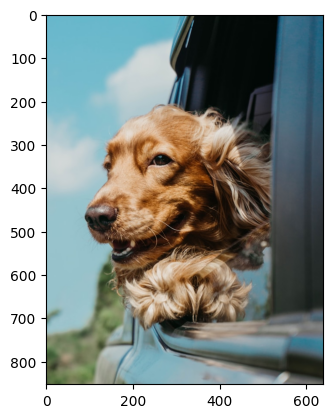

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
im = Image.open(photos_donwload_path / '_-QQuvAwQ-0.jpg')
# im1 = im.resize((64,64)).convert('L')
plt.imshow(im, cmap='gray')
# im1.save('test.jpg')

In [6]:
import numpy as np
np.array(im).shape

(853, 640, 3)

In [7]:
def resize(im, size=(320, 320)):
    (width, height) = im.size
    if height >= width:
        top = int((height - width)/2)
        bottom = top + width
        # bottom = top + size[0]
        new_img = im.crop((0, top, width, bottom))
    if height < width:
        left = int((width - height)/2)
        right = left + height
        new_img = im.crop((left, 0, right, height))
    new_img = new_img.resize(size).convert('L')
    #im1 = im.resize(size, Image.Resampling.LANCZOS).convert('L')
    return new_img

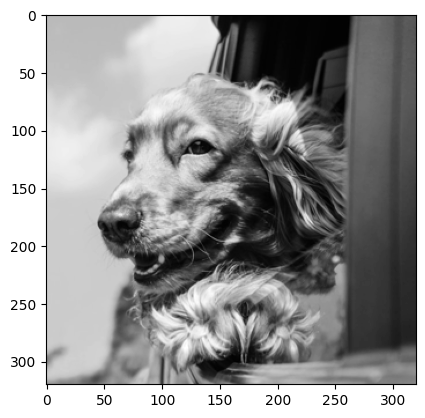

In [8]:
plt.imshow(resize(im, size = (320, 320)), cmap='gray')

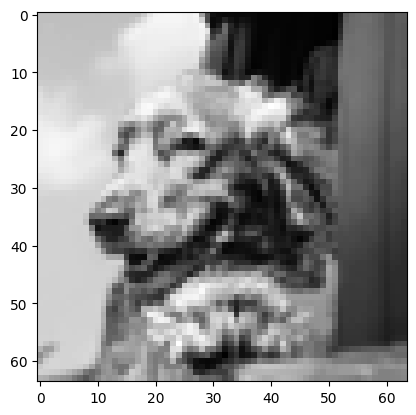

In [9]:
plt.imshow(resize(im, size = (64, 64)), cmap='gray')

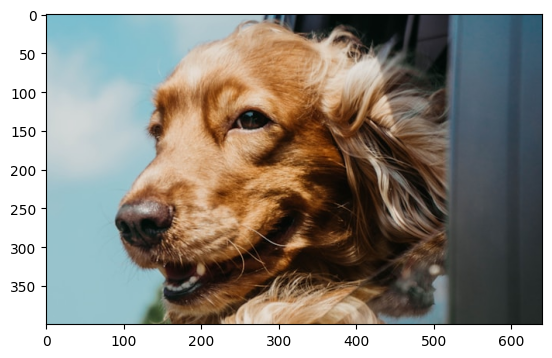

In [10]:
# Test for large photos (create a fake one)
im_large= im.crop((0, 200, 640, 600))
plt.imshow(im_large)

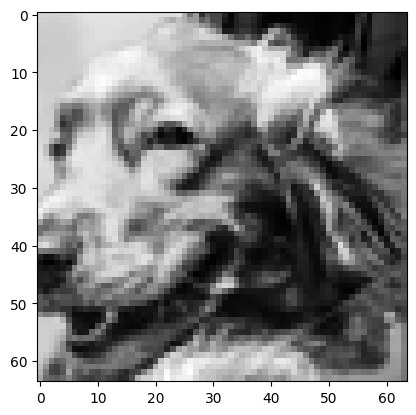

In [11]:
plt.imshow(resize(im_large, size = (64, 64)), cmap='gray')

# Dataset creation

Create the "Dataset" depository before launching (in the same depository as this notebook)

Generate the different datasets of pictures

In [13]:
import glob
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from copy import deepcopy

# pictures generating error : YRJrO0-OP1A.jpg , UsWjYe1FdlU.jpg cut manually
# Number of pictures in each dataset
n_public_train = 5000
n_public_test = 1000
n_private_train = 5000
n_private_test = 1000


photos_path = Path("unsplash-research-dataset-lite-latest") / "photos"
save_path_str = "Dataset/public/Train/"

counter = 0
size_factor = 5

pathlist = Path(photos_path).glob('**/*.jpg')
for path in tqdm(pathlist):
    
    im = Image.open(path)
    im_in = resize(im, size=(320, 320))
    im_out = resize(im, size=(64, 64))

    # img = mpimg.imread(path)
    # img_in = resize_image(img, image_size=(320, 320)) # Resize original image
    # img_out = resize_image(img, image_size=(64, 64)) # generate low resolution b&w image
    
    img_in_filename = save_path_str + "H" + str(format(counter, '05d')) + "_hi.png"
    img_out_filename = save_path_str + "L" + str(format(counter, '05d')) + "_lo.png"
    # print(img_in.dtype)
    # print(img_out.dtype)

    im_in.save(img_in_filename)
    im_out.save(img_out_filename)

    # mpimg.imsave(img_in_filename, img_in, cmap='gray', dpi=72)
    # mpimg.imsave(img_out_filename, img_out, cmap='gray', dpi=72)
    # plt.imshow(img)

    counter += 1
    if counter == n_public_train:
        save_path_str = "Dataset/public/Test/"
    elif counter == n_public_train + n_public_test:
        save_path_str = "Dataset/private/Train/"
    elif counter == n_public_train + n_public_test + n_private_train:
        save_path_str = "Dataset/private/Test/"
    elif counter == n_public_train + n_public_test + n_private_train + n_private_test:
        break
    elif counter >= 25000:
        break



11999it [03:40, 54.31it/s]


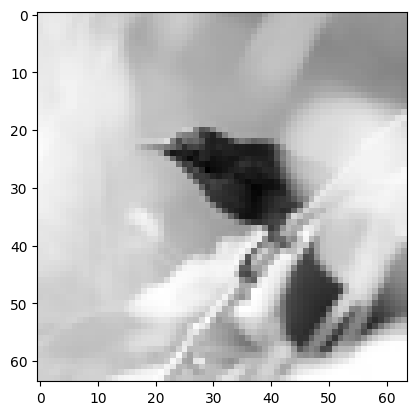

In [14]:
data_repo = 'Dataset/public/Train/'
code = '00020'
plt.imshow(Image.open(data_repo + 'H'+ code + '_hi.png'), cmap='gray')
plt.imshow(Image.open(data_repo + 'L'+ code + '_lo.png'), cmap='gray')

Create numpy arrays for each dataset

In [15]:
import os
def _get_data(path="./Dataset", set = 'public', split='Train'):
    assert split in ['Train', 'Test'], 'split must be either Train or Test'
    assert set in ['public', 'private'], 'set must be either public or private'
    path = os.path.join(path, set, split)
    photos_path = Path(path)
    file_list = os.listdir(photos_path)
    counter = 0
    data_x = []
    data_y = []
    for f in file_list:  # iterate through the files
        fpath = os.path.join(photos_path, f)
        fpath = fpath.replace('\\', '/')
        fpath = fpath.replace('._', '')
        if fpath.endswith('_hi.png'):
            # get the high resolution image
            img = Image.open(fpath)
            
            data_y.append(np.array(img)) # keep only one channel (gray pictures)
            
            # get the corresponding low resolution image
            fpath = fpath.replace('_hi.png', '_lo.png')
            fpath = fpath.replace('H', 'L')
            img = Image.open(fpath)
            data_x.append(np.array(img)) # keep only one channel (gray pictures)
        counter += 1
        if counter >= 25000:
            break
    return data_x, data_y

In [16]:
x_train_public, y_train_public = _get_data(set ='public', split = 'Train') 
x_test_public, y_test_public = _get_data(set ='public', split = 'Test') 
x_train_private, y_train_private = _get_data(set ='private', split = 'Train') 
x_test_private, y_test_private = _get_data(set ='private', split = 'Test') 

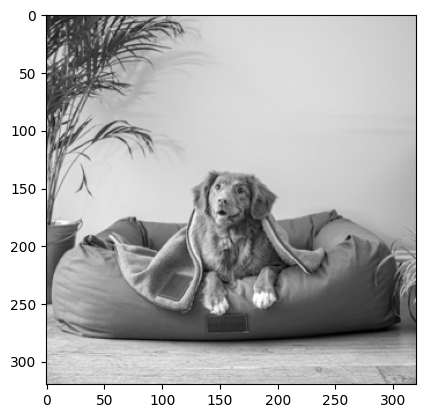

In [17]:
plt.imshow(y_train_private[10], cmap='gray')

In [18]:
## convert the data to tensors
import torch
X_train_public_tensor = [torch.from_numpy(x) for x in tqdm(x_train_public)]
Y_train_public_tensor = [torch.from_numpy(x) for x in tqdm(y_train_public)]
X_test_public_tensor = [torch.from_numpy(x) for x in tqdm(x_test_public)]
Y_test_public_tensor = [torch.from_numpy(x) for x in tqdm(y_test_public)]
X_train_private_tensor = [torch.from_numpy(x) for x in tqdm(x_train_private)]
Y_train_private_tensor = [torch.from_numpy(x) for x in tqdm(y_train_private)]
X_test_private_tensor = [torch.from_numpy(x) for x in tqdm(x_test_private)]
Y_test_private_tensor = [torch.from_numpy(x) for x in tqdm(y_test_private)]

100%|██████████| 1000/1000 [00:00<00:00, 1766766.64it/s]


In [19]:
from torch.utils.data import DataLoader, Dataset

## We now define a customized dataset class

class Dataset_custom(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

In [20]:
train_public_dataset = Dataset_custom(X_train_public_tensor, Y_train_public_tensor)
test_public_dataset = Dataset_custom(X_test_public_tensor, Y_test_public_tensor)
train_private_dataset = Dataset_custom(X_train_private_tensor, Y_train_private_tensor)
test_private_dataset = Dataset_custom(X_test_private_tensor, Y_test_private_tensor)

In [21]:
X_train_public = [item[0].numpy() for item in tqdm(train_public_dataset)]
Y_train_public = [item[1].numpy() for item in tqdm(train_public_dataset)]
X_test_public = [item[0].numpy() for item in tqdm(test_public_dataset)]
Y_test_public = [item[1].numpy() for item in tqdm(test_public_dataset)]

100%|██████████| 1000/1000 [00:00<00:00, 525272.89it/s]


In [22]:
X_train_private = [item[0].numpy() for item in tqdm(train_private_dataset)]
Y_train_private = [item[1].numpy() for item in tqdm(train_private_dataset)]
X_test_private = [item[0].numpy() for item in tqdm(test_private_dataset)]
Y_test_private = [item[1].numpy() for item in tqdm(test_private_dataset)]

100%|██████████| 1000/1000 [00:00<00:00, 982272.60it/s]


In [23]:
X_train_public = np.stack(X_train_public, axis=0)
Y_train_public = np.stack(Y_train_public, axis=0)
X_train_public.shape, Y_train_public.shape

((5000, 64, 64), (5000, 320, 320))

In [24]:
X_test_public = np.stack(X_test_public, axis=0)
Y_test_public = np.stack(Y_test_public, axis=0)
X_test_public.shape, Y_test_public.shape

((1000, 64, 64), (1000, 320, 320))

In [25]:
X_train_private = np.stack(X_train_private, axis=0)
Y_train_private = np.stack(Y_train_private, axis=0)
X_train_private.shape, Y_train_private.shape

((5000, 64, 64), (5000, 320, 320))

In [26]:
X_test_private = np.stack(X_test_private, axis=0)
Y_test_private = np.stack(Y_test_private, axis=0)
X_test_private.shape, Y_test_private.shape

((1000, 64, 64), (1000, 320, 320))

Save data

In [27]:

if not os.path.exists('data'):
    os.makedirs('data')
    os.makedirs('data/public')

In [28]:
X_train_private[0, :5, 50]

array([200, 196, 192, 189, 186], dtype=uint8)

In [29]:
np.save('data/Xtrain.npy', X_train_private)
np.save('data/Ytrain.npy', Y_train_private)
np.save('data/Xtest.npy', X_test_private)
np.save('data/Ytest.npy', Y_test_private)
np.save('data/public/Xtrain.npy', X_train_public)
np.save('data/public/Ytrain.npy', Y_train_public)
np.save('data/public/Xtest.npy', X_test_public)
np.save('data/public/Ytest.npy', Y_test_public)

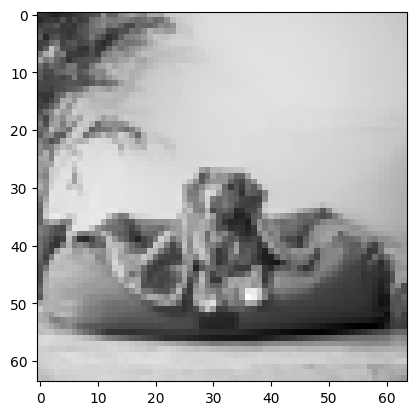

In [30]:
plt.imshow(X_train_private[10], cmap = 'gray')